<a href="https://colab.research.google.com/github/talisma-cassoma/plant-disease-study/blob/main/Plant_disease_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

deps

In [4]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Is GPU Working?
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Which GPU Am I Using?
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1135062514490276057
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8314812528324329996
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
!nvidia-smi

Thu Apr  4 22:04:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              27W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

dataset: https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset?resource=download

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# Define directories
image_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/images"
mask_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/masks"
working_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/working/"
train_image_dir = os.path.join(working_dir, "legion/image/img")
train_mask_dir = os.path.join(working_dir, "legion/mask/img")
test_image_dir = os.path.join(working_dir, "legiont/image/img")

# Set the proportion of data to be used for validation
validation_split = 0.2

# List all image files
image_files = os.listdir(image_source_dir)

# Calculate the number of samples for validation and train
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files) - num_validation_samples

# Function to check if directories have the correct number of files
def check_directory(dir_path, expected_count):
    if not os.path.exists(dir_path):
        return False
    files = os.listdir(dir_path)
    if len(files) != expected_count:
        return False
    return True

# Check if working directory and subdirectories exist with the correct number of files
if not (check_directory(train_image_dir, num_train_samples) and
        check_directory(train_mask_dir, num_train_samples) and
        check_directory(test_image_dir, num_validation_samples)):
    # Remove existing working directory if it exists
    if os.path.exists(working_dir):
        shutil.rmtree(working_dir)

    # Create train and test directories
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)

    # Randomly shuffle the list of files
    random.shuffle(image_files)

    # Move files to train and test directories
    for i, image_file in enumerate(tqdm(image_files, desc="Copying to train and test directories")):
        source_image_path = os.path.join(image_source_dir, image_file)
        source_mask_file = os.path.splitext(image_file)[0] + ".png"
        source_mask_path = os.path.join(mask_source_dir, source_mask_file)
        if i < num_train_samples:
            shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
            shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))
        else:
            shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Data separation complete.")


Data separation complete.


In [7]:
import os

# Define directories
image_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/images"
mask_source_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/aug_data/aug_data/masks"
working_dir = "/content/drive/MyDrive/plant-disease-segmentation-dataset/working/"
train_image_dir = os.path.join(working_dir, "legion/image/img")
train_mask_dir = os.path.join(working_dir, "legion/mask/img")
test_image_dir = os.path.join(working_dir, "legiont/image/img")

# Set the proportion of data to be used for validation
validation_split = 0.2

# List all image files
image_files = os.listdir(image_source_dir)

# Calculate the number of samples for validation and train
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files) - num_validation_samples

# Define a function to count the number of images in a directory
def count_images_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Calculate the correct number of images in each directory
correct_num_train_images = count_images_in_directory(train_image_dir)
correct_num_train_masks = count_images_in_directory(train_mask_dir)
correct_num_test_images = count_images_in_directory(test_image_dir)

# Print the directory structure
print("Directory Structure:")
print("    /content/drive/MyDrive/plant-disease-segmentation-dataset/")
print("        aug_data/")
print("            aug_data/")
print("                images/")
print("                    - Original images")
print("                masks/")
print("                    - Corresponding mask images")
print("        working/")
print("            legion/")
print("                image/")
print("                    img/")
print("                        - Training images")
print("                mask/")
print("                    img/")
print("                        - Training mask images")
print("            legiont/")
print("                image/")
print("                    img/")
print("                        - Test images")
print()

# Print the correct number of images in each directory
print("Correct Number of Images in Each Directory:")
print("    Train Image Directory:", correct_num_train_images)
print("    Train Mask Directory:", correct_num_train_masks)
print("    Test Image Directory:", correct_num_test_images)
print()

# Print the correct values of all variables
print("Correct Values of All Variables:")
print("    train_image_dir:", train_image_dir)
print("    train_mask_dir:", train_mask_dir)
print("    test_image_dir:", test_image_dir)
print("    num_validation_samples:", num_validation_samples)
print("    num_train_samples:", num_train_samples)


Directory Structure:
    /content/drive/MyDrive/plant-disease-segmentation-dataset/
        aug_data/
            aug_data/
                images/
                    - Original images
                masks/
                    - Corresponding mask images
        working/
            legion/
                image/
                    img/
                        - Training images
                mask/
                    img/
                        - Training mask images
            legiont/
                image/
                    img/
                        - Test images

Correct Number of Images in Each Directory:
    Train Image Directory: 2352
    Train Mask Directory: 2352
    Test Image Directory: 588

Correct Values of All Variables:
    train_image_dir: /content/drive/MyDrive/plant-disease-segmentation-dataset/working/legion/image/img
    train_mask_dir: /content/drive/MyDrive/plant-disease-segmentation-dataset/working/legion/mask/img
    test_image_dir: /content/drive/My

visualizating data

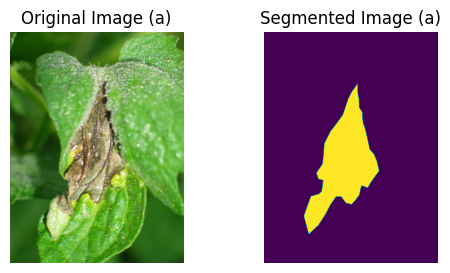

----------------------------------------------------


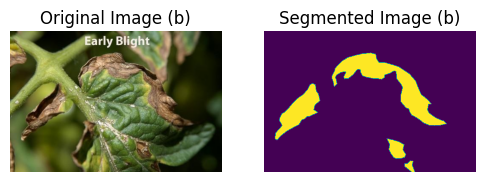

----------------------------------------------------


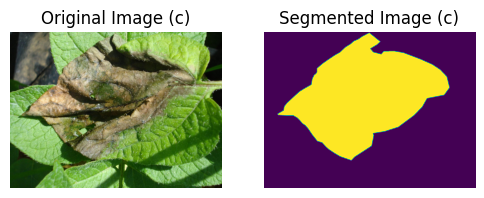

----------------------------------------------------


In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_images(loops=1, figsize=(8, 4)):
    mask_files = os.listdir(train_mask_dir)
    random.shuffle(mask_files)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(loops):
        mask_file = mask_files[i]
        img_name = os.path.splitext(mask_file)[0]
        img_path = os.path.join(train_image_dir, img_name + ".jpg")
        mask_path = os.path.join(train_mask_dir, mask_file)
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].imshow(img)
        axes[0].set_title('Original Image ({})'.format(alphabet[i]))
        axes[0].axis('off')
        axes[1].imshow(mask)
        axes[1].set_title('Segmented Image ({})'.format(alphabet[i]))
        axes[1].axis('off')
        plt.show()
        print("----------------------------------------------------")

show_images(3, figsize=(6, 3))  # Adjust the figsize as needed


resizing images for train:

In [9]:
# Setting the seed for random number generation
seed = 42
np.random.seed = seed

# Image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Creating arrays to store training data
X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')

image_files = os.listdir(train_image_dir)
# Processing training images
for i in tqdm(range(num_train_samples), desc='Processing images'):
    # Get image and mask paths
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    # Load and resize image
    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    # Load and resize mask
    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask

# Creating arrays to store test data
X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')

# Processing test images
image_files = os.listdir(test_image_dir)
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    # Get test image path
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)

    # Store test image size
    sizes_test.append([img.shape[0], img.shape[1]])

    # Resize test image
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # Assign resized test image to X_test (NOTE: Should be X_test[i], not X_train[i])
    X_train[i] = img


Resizing training images and masks


Processing images: 100%|██████████| 2352/2352 [08:49<00:00,  4.44it/s]


Resizing test images


Processing images: 100%|██████████| 588/588 [01:31<00:00,  6.43it/s]


vizulizing the resized images:

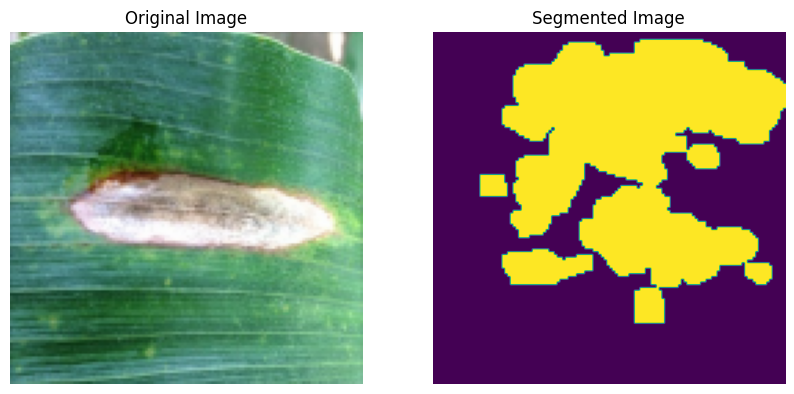

In [10]:
image_x = 3

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(X_train[image_x])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the segmented image
axes[1].imshow(np.squeeze(Y_train[image_x]))
axes[1].set_title('Segmented Image')
axes[1].axis('off')

plt.show()

building UNet model:

In [11]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d_5[0][0]']            
                                                                                              

train

Epoch 1/25
133/133 [==============================] - 7s 48ms/step - loss: 0.3935 - accuracy: 0.8318 - val_loss: 0.3372 - val_accuracy: 0.8578
Epoch 2/25
133/133 [==============================] - 6s 46ms/step - loss: 0.3882 - accuracy: 0.8348 - val_loss: 0.3145 - val_accuracy: 0.8695
Epoch 3/25
133/133 [==============================] - 6s 46ms/step - loss: 0.3818 - accuracy: 0.8383 - val_loss: 0.3312 - val_accuracy: 0.8658
Epoch 4/25
133/133 [==============================] - 6s 46ms/step - loss: 0.3813 - accuracy: 0.8395 - val_loss: 0.3185 - val_accuracy: 0.8702


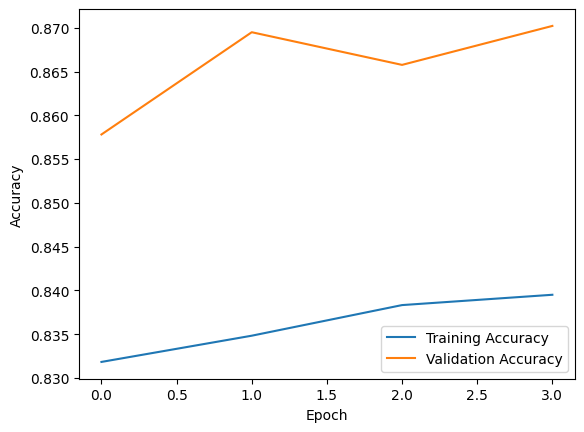

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Define the directory path
directory = '/content/drive/MyDrive/plant-disease-segmentation-dataset/tmp/model'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Modify the ModelCheckpoint callback to save in the created directory
checkpointer = tf.keras.callbacks.ModelCheckpoint(os.path.join(directory, 'Leaf_segmentation.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
unetacc = history.history['accuracy'][-1]
# Save the final model
model.save(os.path.join(directory, 'Leaf_segmentation_final.h5'))


save the model



In [ ]:
# code here

19/19 [==============================] - 0s 14ms/step


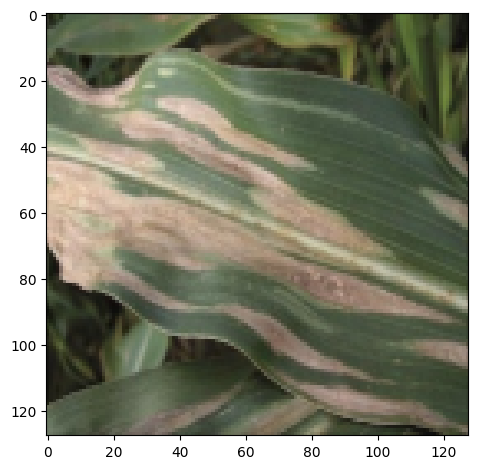

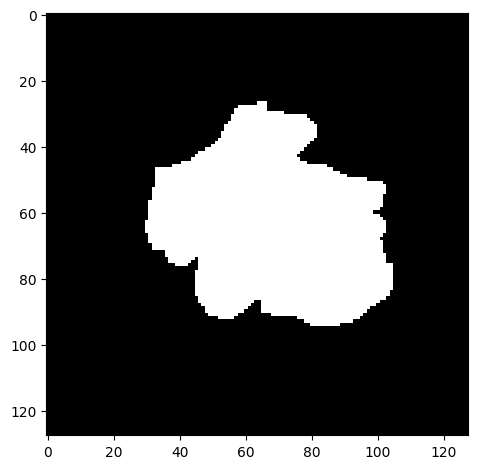

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


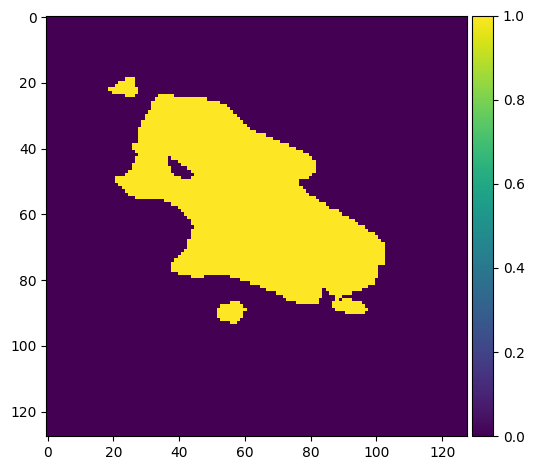

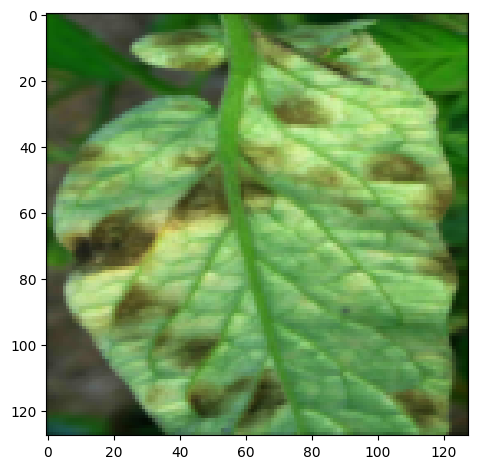

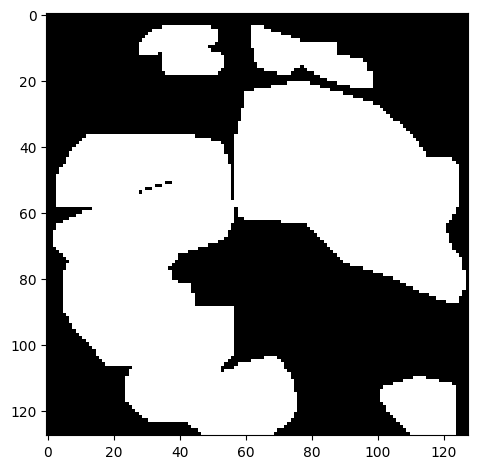

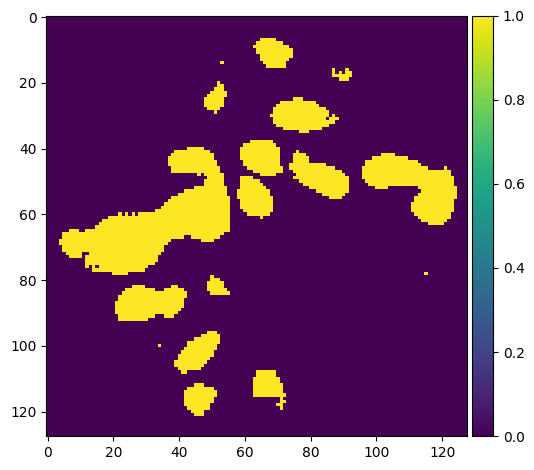

In [12]:
# Load the model
model_path = '/content/drive/MyDrive/plant-disease-segmentation-dataset/tmp/model/Leaf_segmentation_final.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Predictions using the loaded model
preds_train = loaded_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = loaded_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = loaded_model.predict(X_test, verbose=1)

# Thresholding predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Custom Model

Epoch 1/25
133/133 [==============================] - 6s 46ms/step - loss: 0.3005 - accuracy: 0.8773 - val_loss: 0.2899 - val_accuracy: 0.8859
Epoch 2/25
133/133 [==============================] - 6s 49ms/step - loss: 0.2944 - accuracy: 0.8794 - val_loss: 0.2851 - val_accuracy: 0.8827
Epoch 3/25
133/133 [==============================] - 6s 46ms/step - loss: 0.2890 - accuracy: 0.8814 - val_loss: 0.2900 - val_accuracy: 0.8828
Epoch 4/25
133/133 [==============================] - 6s 48ms/step - loss: 0.2846 - accuracy: 0.8834 - val_loss: 0.2835 - val_accuracy: 0.8856
Epoch 5/25
133/133 [==============================] - 6s 47ms/step - loss: 0.2792 - accuracy: 0.8851 - val_loss: 0.2954 - val_accuracy: 0.8796
Epoch 6/25
133/133 [==============================] - 7s 55ms/step - loss: 0.2798 - accuracy: 0.8853 - val_loss: 0.2871 - val_accuracy: 0.8848
Epoch 1/25
133/133 [==============================] - 13s 50ms/step - loss: 0.2761 - accuracy: 0.8875 - val_loss: 0.2863 - val_accuracy: 0.884

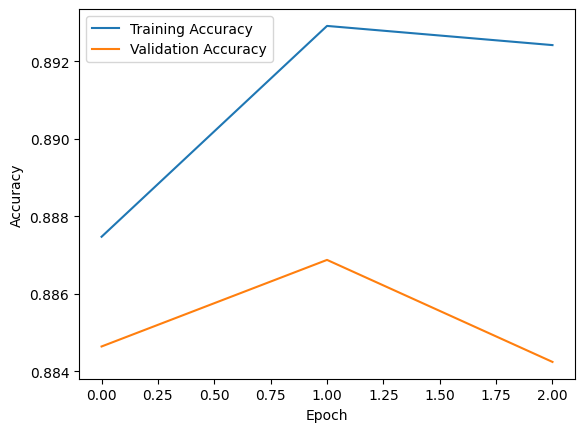

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Define the directory path
directory = '/content/drive/MyDrive/plant-disease-segmentation-dataset/tmp/model'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Modify the ModelCheckpoint callback to save in the created directory
checkpointer = tf.keras.callbacks.ModelCheckpoint(os.path.join(directory, 'Leaf_segmentation.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

custom_model = Sequential()

# Encoder
custom_model.add(Conv2D(32, (3, 3), activation='leaky_relu', padding='same', input_shape=(128, 128, 3)))
custom_model.add(MaxPooling2D((2, 2), padding='same'))
custom_model.add(Conv2D(64, (3, 3), activation='leaky_relu', padding='same'))
custom_model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
custom_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
custom_model.add(UpSampling2D((2, 2)))
custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
custom_model.add(UpSampling2D((2, 2)))
custom_model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

custom_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = custom_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

mymodel = history.history['accuracy'][-1]
custom_model.save(os.path.join(directory, 'custom_leaf_segmentation.h5'))

19/19 [==============================] - 0s 14ms/step


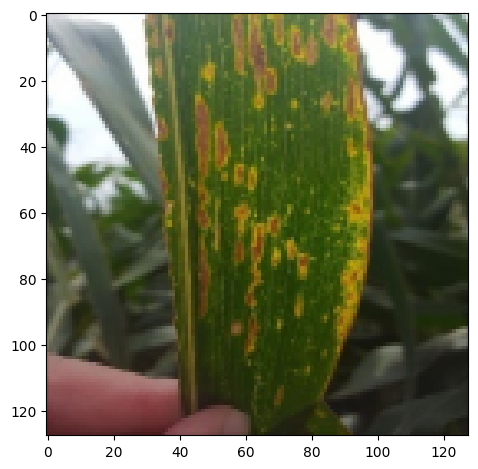

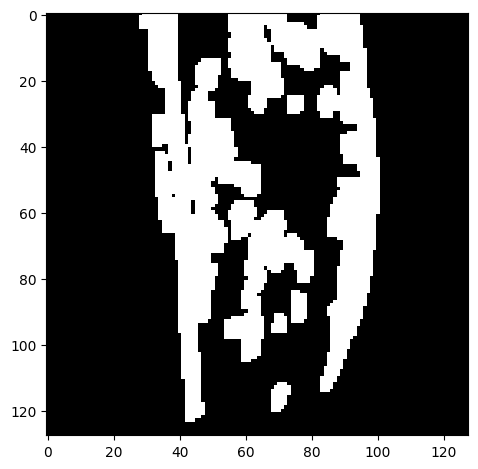

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


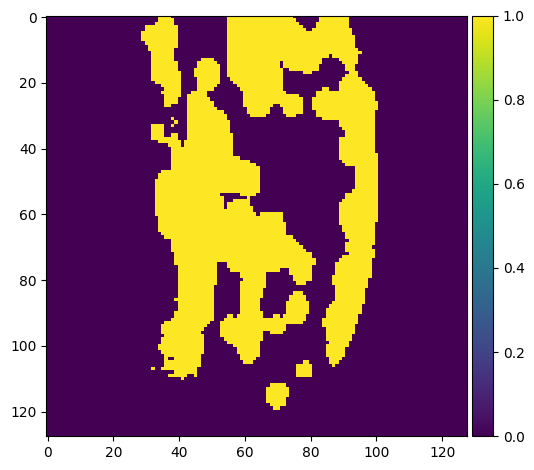

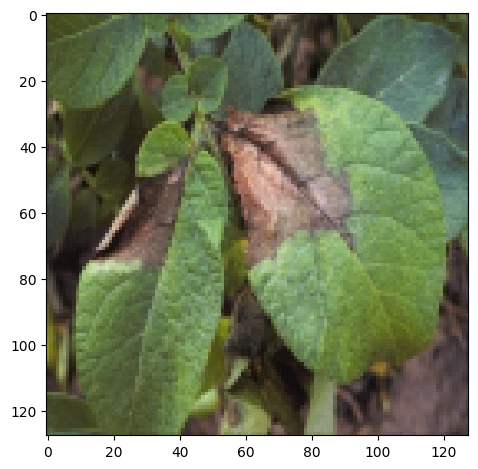

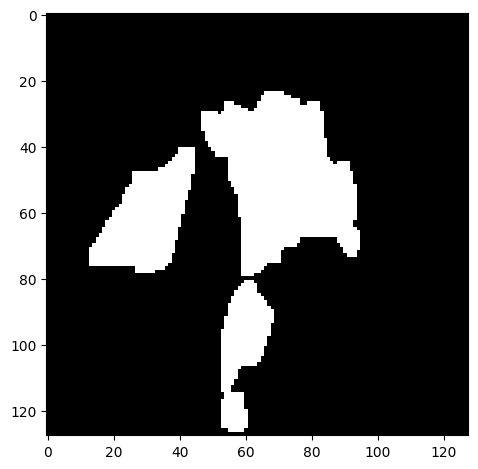

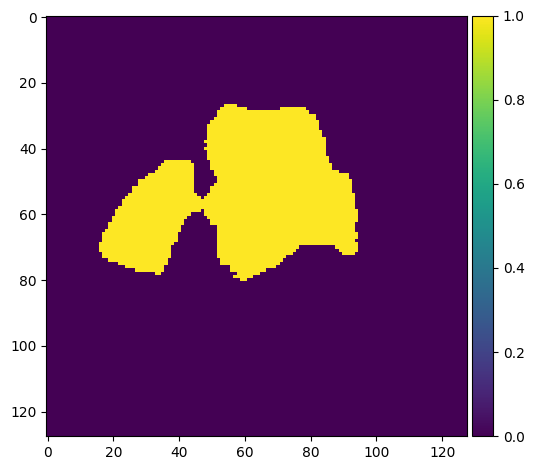

In [19]:
idx = 7


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# K-Means Clustering

In [22]:
img = cv2.imread("/content/drive/MyDrive/plant-disease-segmentation-dataset/working/legiont/image/img/00003_3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()#plotting
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

<Figure size 640x480 with 0 Axes>

In [23]:
original_image = cv2.imread("/content/drive/MyDrive/plant-disease-segmentation-dataset/working/legiont/image/img/00003_3.jpg")
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [24]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
result_image = cv2.bitwise_not(result_image)

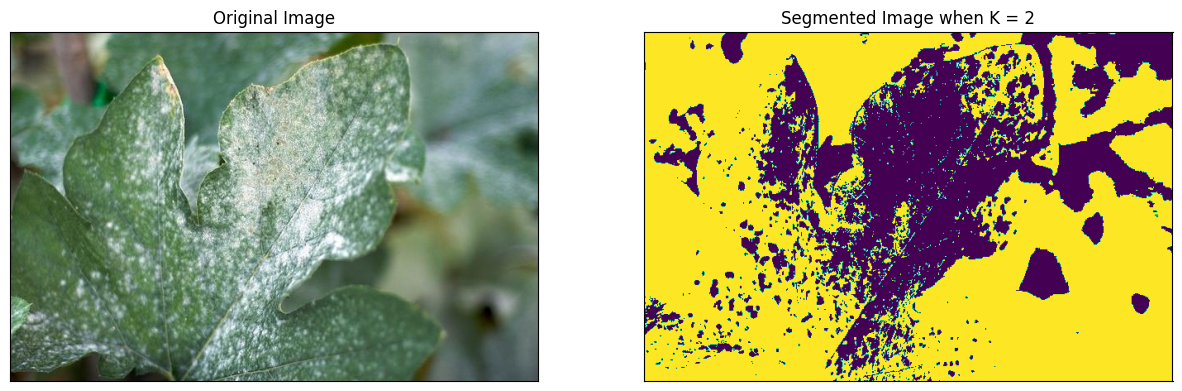

In [25]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()